In [ ]:
import pandas as pd
import pdb
import re
import string
from sklearn.model_selection import train_test_split
from gensim import models
from keras.models import Sequential
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DL_Final_Project_Akshada/

/content/drive/MyDrive/DL_Final_Project_Akshada


### ***Creating the dataset with technical indicators and fourier transforms for AAPL***

In [ ]:
df = pd.read_csv('AAPL.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

        Date      Open      High       Low     Close  Adj Close     Volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100453  469033600
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095213  175884800
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088224  105728000
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090408   86441600
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093029   73449600
            Date        Open        High  ...       Close   Adj Close     Volume
10318 2021-11-12  148.429993  150.399994  ...  149.990005  149.990005   63632600
10319 2021-11-15  150.369995  151.880005  ...  150.000000  150.000000   59222800
10320 2021-11-16  149.940002  151.490005  ...  151.000000  151.000000   59256200
10321 2021-11-17  151.000000  155.000000  ...  153.490005  153.490005   88807000
10322 2021-11-18  153.710007  158.669998  ...  157.869995  157.869995  137659100

[5 rows x 7 columns]
(10323, 7)
Index(['Date', 'Open', 'High', 

In [ ]:
df=df[(df['Date'] > '2016-12-04')]#Filtering out the dates before 5 dec 2016

In [ ]:
df.head

<bound method NDFrame.head of             Date        Open        High  ...       Close   Adj Close     Volume
9074  2016-12-05   27.500000   27.507500  ...   27.277500   25.675814  137298000
9075  2016-12-06   27.375000   27.590000  ...   27.487499   25.873482  104782000
9076  2016-12-07   27.315001   27.797501  ...   27.757500   26.127632  119994800
9077  2016-12-08   27.715000   28.107500  ...   28.030001   26.384127  108273200
9078  2016-12-09   28.077499   28.674999  ...   28.487499   26.814766  137610400
...          ...         ...         ...  ...         ...         ...        ...
10318 2021-11-12  148.429993  150.399994  ...  149.990005  149.990005   63632600
10319 2021-11-15  150.369995  151.880005  ...  150.000000  150.000000   59222800
10320 2021-11-16  149.940002  151.490005  ...  151.000000  151.000000   59256200
10321 2021-11-17  151.000000  155.000000  ...  153.490005  153.490005   88807000
10322 2021-11-18  153.710007  158.669998  ...  157.869995  157.869995  13765910

### ***Plotting Daily closing price for AAPL***

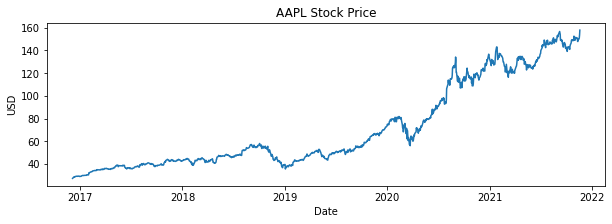

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='AAPL stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="AAPL Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

### ***Calculate technical indicators***

In [ ]:
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    # pdb.set_trace() 
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
T_df = get_technical_indicators(df)

### ***Perform fourier transform***

In [ ]:
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [ ]:
dataset.shape

(1229, 15)

In [ ]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    # pdb.set_trace() 
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [ ]:
dataset_F = get_fourier_transfer(dataset)

### ***Concatenating the two datasets consisting of the technical indicators and fourier transformed features***

In [ ]:
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [ ]:
Final_data.shape#This will consist of technical indicators and fourier transformed feautures (From 24 dec 2016 to 18 Nov 2021)

(1229, 21)

In [ ]:
Final_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301880,84472400,29.116429,28.736071,-0.026784,0.522725,29.781522,27.690621,29.015444,3.332383,89.367987,-0.064600,91.990600,-0.043657,89.638821,-0.022994
1,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440718,88774400,29.119643,28.825357,-0.010756,0.424550,29.674457,27.976258,29.106815,3.337636,88.858715,-0.064976,90.879462,-0.044106,87.886934,-0.022844
2,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746634,127007600,29.142857,28.920119,-0.000241,0.350304,29.620728,28.219511,29.353939,3.349114,88.349230,-0.065341,89.766886,-0.044525,86.138158,-0.022638
3,2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000782,134247600,29.222500,29.014881,-0.010163,0.314277,29.643434,28.386328,29.616312,3.358551,87.839583,-0.065694,88.653280,-0.044913,84.393875,-0.022373
4,2017-01-10,29.692499,29.844999,29.575001,29.777500,28.029022,97848400,29.307500,29.098095,-0.043933,0.321986,29.742068,28.454123,29.723771,3.359594,87.329820,-0.066037,87.539052,-0.045268,82.655460,-0.022047


In [ ]:
Final_data=Final_data.set_index('Date')#setting date column as index

In [ ]:
idx = pd.date_range('12-24-2016', '11-18-2021')
Final_data = Final_data.reindex(idx)#Filling missing dates with NaN

In [ ]:
Final_data.shape#This will consist of technical indicators and fourier transformed feautures (Continuous rows From 24 dec 2016 to 18 Nov 2021)

(1791, 20)

In [ ]:
Final_data['Date'] = Final_data.index#Converting index back to Date column

In [ ]:
Final_data=Final_data.reset_index(drop=True)

In [ ]:
Final_data.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-24
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-25
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-26
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-27
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-28


In [ ]:
Final_data.to_csv('Data_tech_ind_fourier_trans.csv')

In [ ]:
#counting null values
print (Final_data.isnull().sum())

Unnamed: 0              0
Open                  562
High                  562
Low                   562
Close                 562
Adj Close             562
Volume                562
MA7                   562
MA21                  562
MACD                  562
20SD                  562
upper_band            562
lower_band            562
EMA                   562
logmomentum           562
absolute of 3 comp    562
angle of 3 comp       562
absolute of 6 comp    562
angle of 6 comp       562
absolute of 9 comp    562
angle of 9 comp       562
Date                    0
dtype: int64


### ***Google trend data***

In [ ]:
google_orig=pd.read_csv('dataset_google-trends-scraper_2021-11-28_21-30-07-804.csv')

In [ ]:
google_orig


,Term / Date,AAPL
0,4-Dec-16,15
1,11-Dec-16,15
2,18-Dec-16,14
3,25-Dec-16,10
4,1-Jan-17,14
...,...,...
255,24-Oct-21,29
256,31-Oct-21,23
257,7-Nov-21,19
258,14-Nov-21,22


In [ ]:
google_orig['Term / Date'] = pd.to_datetime(google_orig['Term / Date'])

In [ ]:
# Available google trend data to market is lagged. For example, for this week, I can only see past week trend.
google = pd.DataFrame(columns=['date', 'search'])
for i, row in enumerate(google_orig.iterrows()):
    t = row[1]['Term / Date']
    
    # today (t) trend score is only visible & used for t+1 to t+7
    for offset in range(1, 8):
        # pdb.set_trace()

        newrow = {'date': t + pd.DateOffset(offset),
                  'search': row[1]['AAPL']}
        google = google.append(newrow, ignore_index=True)
# google

In [ ]:
google.tail(10)

,date,search
1810,2021-11-19,22
1811,2021-11-20,22
1812,2021-11-21,22
1813,2021-11-22,23
1814,2021-11-23,23
1815,2021-11-24,23
1816,2021-11-25,23
1817,2021-11-26,23
1818,2021-11-27,23
1819,2021-11-28,23


In [ ]:
# Merge with Final_data dataframe
Final_data['search'] = 0
for i, row in enumerate(Final_data.iterrows()):
    # pdb.set_trace()
    try:
        Final_data.loc[i, 'search'] = google.loc[google['date'] == row[1]['Date'], 'search'].values[0]
    except:
        # if no available search index, use the most recent one
        Final_data.loc[i, 'search'] = google['search'][len(google)-1]

In [ ]:
Final_data.shape#This will consist of technical indicators, fourier transformed features and google trend data (From 24 dec 2016 to 18 Nov 2021)


(1791, 23)

In [ ]:
Final_data.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-24,14
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-25,14
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-26,10
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-27,10
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-28,10


In [ ]:
Final_data.to_csv('Data_google_trend.csv')

### ***Covid data***

In [ ]:
covid=pd.read_csv('owid-covid-data.csv')

In [ ]:
covid.tail()

,iso_code,continent,location,date,total_cases,total_deaths,deathIncrease,positiveIncrease,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
677,USA,North America,United States,11/29/2021,48438876,778705.0,1962,196973,1962.0,835.286,145499.197,591.661,235.939,2339.050,5.893,2.509,1.22,13356.0,40.118,51744.0,155.427,NaN,NaN,NaN,NaN,341749.0,665107373.0,1997.829,1.027,841514.0,2.528,0.093,10.7,tests performed,463650771.0,234115595.0,196175491.0,42388305.0,1450645.0,970522.0,139.65,70.51,59.09,12.77,2923.0,262882.0,0.079,50.46,332915074,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
678,USA,North America,United States,11/30/2021,48555974,780140.0,1435,117098,1435.0,854.286,145850.933,351.735,246.533,2343.360,4.310,2.566,1.24,13535.0,40.656,52581.0,157.941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,465037318.0,234428706.0,196450249.0,43198447.0,1386547.0,936016.0,140.07,70.61,59.17,13.01,2819.0,241290.0,0.073,50.46,332915074,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
679,USA,North America,United States,12/1/2021,48691353,782100.0,1960,135379,1960.0,896.429,146257.580,406.647,256.835,2349.248,5.887,2.693,1.24,13649.0,40.998,53284.0,160.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466200524.0,234700366.0,196671131.0,43877281.0,1163206.0,922429.0,140.42,70.69,59.24,13.22,2778.0,225439.0,0.068,NaN,332915074,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
680,USA,North America,United States,12/2/2021,48832228,785900.0,3800,140875,3800.0,1386.714,146680.736,423.156,303.296,2360.662,11.414,4.165,NaN,13678.0,41.086,53169.0,159.707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466348129.0,234743862.0,196693863.0,43958302.0,147605.0,940439.0,140.46,70.70,59.24,13.24,2833.0,230658.0,0.069,NaN,332915074,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN
681,USA,North America,United States,12/3/2021,48990127,787695.0,1795,157899,1795.0,1606.000,147155.028,474.292,349.126,2366.054,5.392,4.824,NaN,13657.0,41.022,53086.0,159.458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466348132.0,234743864.0,196693864.0,43958302.0,3.0,783969.0,140.46,70.70,59.24,13.24,2361.0,187936.0,0.057,NaN,332915074,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN


In [ ]:
# Merge with stock price
# Lag for one day. Market can only see covid statistics for yesterday.
Final_data['COVID positiveIncrease'] = 0
Final_data['COVID deathIncrease'] = 0
for i, row in enumerate(Final_data.iterrows()):

    try:
        Final_data.loc[i, 'COVID positiveIncrease'] = covid.loc[pd.to_datetime(covid['date']) == pd.to_datetime(row[1]['Date']) - pd.DateOffset(1), 'positiveIncrease'].values[0]
        Final_data.loc[i, 'COVID deathIncrease'] = covid.loc[pd.to_datetime(covid['date']) == pd.to_datetime(row[1]['Date']) - pd.DateOffset(1), 'deathIncrease'].values[0]
        # pdb.set_trace()
    except:
        Final_data.loc[i, 'COVID positiveIncrease'] = 0
        Final_data.loc[i, 'COVID deathIncrease'] = 0

In [ ]:
Final_data.head()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search,COVID positiveIncrease,COVID deathIncrease
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-24,14,0,0
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-25,14,0,0
2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-26,10,0,0
3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-27,10,0,0
4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-28,10,0,0


In [ ]:
Final_data.to_csv('Data_google_trends_COVID.csv')#this dataframe will contain technical indicators, fourier transformed features, google trend data, covid data (From 24 dec 2016 to 18 Nov 2021)

### ***Sentiment analysis bullish and bearish scores***

In [ ]:
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    
    r = requests.get(url)
    data = json.loads(r.text)
    
    return data['data']

def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [ ]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before="1638492305"#Dec 2 2021
after = "1498867200" #july 1 2017
query = ""
subCount = 0
subStats = []

In [ ]:
data = getPushshiftData(query, after, before, sub)#list of 100 dictionaries

https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1498867200&before=1638492305&subreddit=wallstreetbets


In [ ]:
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    try:
        data = getPushshiftData(query, after, before, sub)
    except:
        pass

Streaming output truncated to the last 5000 lines.
2021-07-30 04:16:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627618561&before=1638492305&subreddit=wallstreetbets
100
2021-07-30 08:33:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627633997&before=1638492305&subreddit=wallstreetbets
99
2021-07-30 12:49:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627649371&before=1638492305&subreddit=wallstreetbets
99
2021-07-30 12:49:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627649371&before=1638492305&subreddit=wallstreetbets
100
2021-07-30 14:47:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627656460&before=1638492305&subreddit=wallstreetbets
100
2021-07-30 14:47:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1627656460&before=1638492305&subreddit=wallstreetbets
100
2021-07-30 16:25:14
https://api.pushshi

In [ ]:
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_3=pd.DataFrame(data)

In [ ]:
df_3.tail()

,id,title,url,date,flair
3091628,r6a2k9,"Faced with stock market volatility, I teach yo...",https://www.reddit.com/r/wallstreetbets/commen...,2021-12-01,News
3091629,r6aesc,Fudelity Puts?,https://www.reddit.com/r/wallstreetbets/commen...,2021-12-01,Discussion
3091630,r6alf5,But is this graph my impression or is it very ...,https://www.reddit.com/gallery/r6alf5,2021-12-01,Discussion
3091631,r6aq30,Opinions?,https://i.redd.it/v8kcw9pbew281.jpg,2021-12-01,Discussion
3091632,r6auq2,Im a year late. Enjoy,https://v.redd.it/si8rlzh1gw281,2021-12-01,Meme


In [ ]:
## create bull and bear sentiment scores for each day using keywords

titles=df_3['title'].tolist()
titles=list([(title.lower()) for title in titles])

bull_words=['call', 'long', 'all in', 'moon', 'going up', 'rocket', 'buy', 'long term', 'green']
bear_words=['put', 'short', 'going down', 'drop', 'bear', 'sell', 'red']

bull_scores=[]
bear_scores=[]
for title in titles:
    bull=False
    bear=False
    for word in bull_words:
        if word in title:
            bull=True
    if re.findall(r'(\b\d{1,4}[c]\b)|(\b\d{1,4}[ ][c]\b)', title):
            bull=True
            
    for word in bear_words:
        if word in title:
            bear=True
    if re.findall(r'(\b\d{1,4}[p]\b)|(\b\d{1,4}[ ][p]\b)', title):
            bear=True
            
    if bull==True and bear==True:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==False and bear==False:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==True and bear==False:
        bull_scores.append(1)
        bear_scores.append(0)
    if bull==False and bear==True:
        bull_scores.append(0)
        bear_scores.append(1)
        
df_3['bull score']=bull_scores#The bull score will be 1 for a given day when the market is bullish, If the market is bearish or bullish and bearish or none, the score will be 0
df_3['bear score']=bear_scores#The bear score will be 1 for a given day when the market is bearish, If the market is bullish or bullish and bearish or none, the score will be 0

In [ ]:
df_3.shape

(3091633, 7)

In [ ]:
## remove irrelevant flairs

indeces=[]
flairs=df_3['flair'].tolist()
for n in range(len(flairs)):
    if flairs[n]=='DD' or flairs[n]=='Discussion' or flairs[n]=='YOLO' or flairs[n]=='Fundamentals' or flairs[n]=='Stocks':
        indeces.append(n)
df_4=df_3.iloc[indeces]

In [ ]:
df_4.shape

(1585080, 7)

In [ ]:
## standardize scores using total scores for day

scores_df=df_4.groupby('date').sum()
scores_df['bull score']=scores_df['bull score']/df_4.groupby('date').count()['bull score']#Getting an average score for a given day by counting the number of bullish titles and dividing by the total num of titles
scores_df['bear score']=scores_df['bear score']/df_4.groupby('date').count()['bear score']#Getting an average score for a given day by counting the number of bearish titles and dividing by the total num of titles

In [ ]:
scores_df.shape#This dataset will contain the daily bullish and bearish scores and will be from 1 July 2017 to 1 Dec 2021

(1585, 2)

In [ ]:
scores_df=pd.read_csv('bull_bear_score.csv')

In [ ]:
#counting null values
print (scores_df.isnull().sum())

Unnamed: 0     0
bull score    30
bear score    30
Date           0
dtype: int64


In [ ]:
scores_df.shape

(1585, 4)

In [ ]:
scores_df = scores_df.dropna()

In [ ]:
#counting null values
print (scores_df.isnull().sum())

Unnamed: 0    0
bull score    0
bear score    0
Date          0
dtype: int64


In [ ]:
scores_df.tail()

,bull score,bear score,Date
1610,0.147982,0.089686,2021-11-27
1611,0.123288,0.123288,2021-11-28
1612,0.133838,0.126263,2021-11-29
1613,0.144737,0.085873,2021-11-30
1614,0.117647,0.068627,2021-12-01


In [ ]:
scores_df=scores_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
#counting null values
print (scores_df.isnull().sum())

bull score    0
bear score    0
Date          0
dtype: int64


### ***Applying fourier transform on the bullish and bearish scores***

In [ ]:
## fourier transform

close_fft = np.fft.fft(np.asarray(scores_df['bull score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
# pdb.set_trace()

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    fft_com = pd.DataFrame({'fft': np.fft.ifft(fft_list_m10)})
    scores_df['fourier bull '+str(num_)]=fft_com['fft'].apply(lambda x: np.abs(x))

close_fft = np.fft.fft(np.asarray(scores_df['bear score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
# pdb.set_trace()

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    fft_com = pd.DataFrame({'fft': np.fft.ifft(fft_list_m10)})
    scores_df['fourier bear '+str(num_)]=fft_com['fft'].apply(lambda x: np.abs(x))

In [ ]:
scores_df.head()

,bull score,bear score,Date,fourier bull 10,fourier bull 30,fourier bear 10,fourier bear 30
0,0.000000,0.00,2017-07-01,0.141086,0.147308,0.100437,0.101678
1,0.200000,0.20,2017-07-02,0.141930,0.147118,0.100488,0.100526
2,0.666667,0.00,2017-07-03,0.142778,0.146810,0.100537,0.099251
3,0.000000,0.25,2017-07-04,0.143631,0.146382,0.100585,0.097860
4,0.400000,0.00,2017-07-05,0.144487,0.145833,0.100630,0.096361


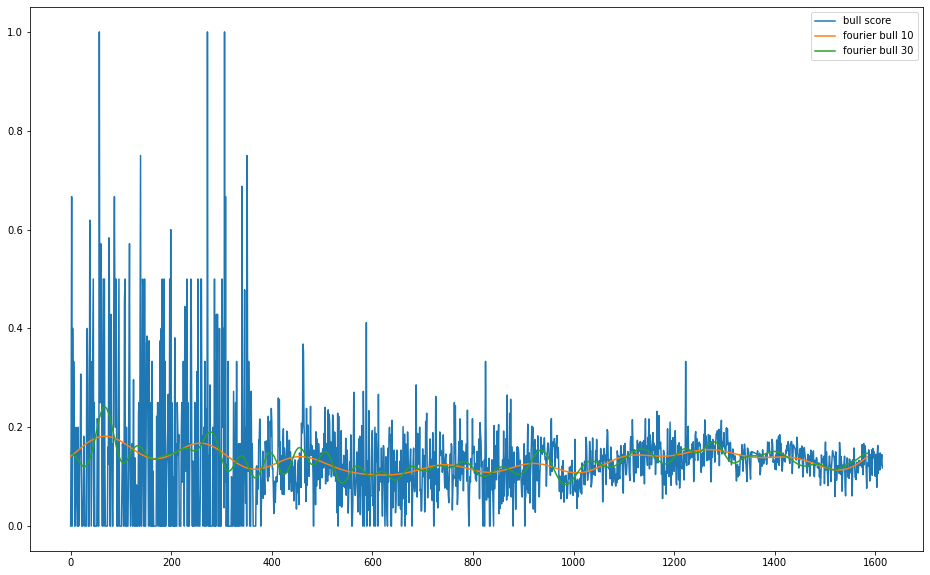

In [ ]:
scores_df[['bull score', 'fourier bull 10', 'fourier bull 30']].plot(figsize=(16, 10));

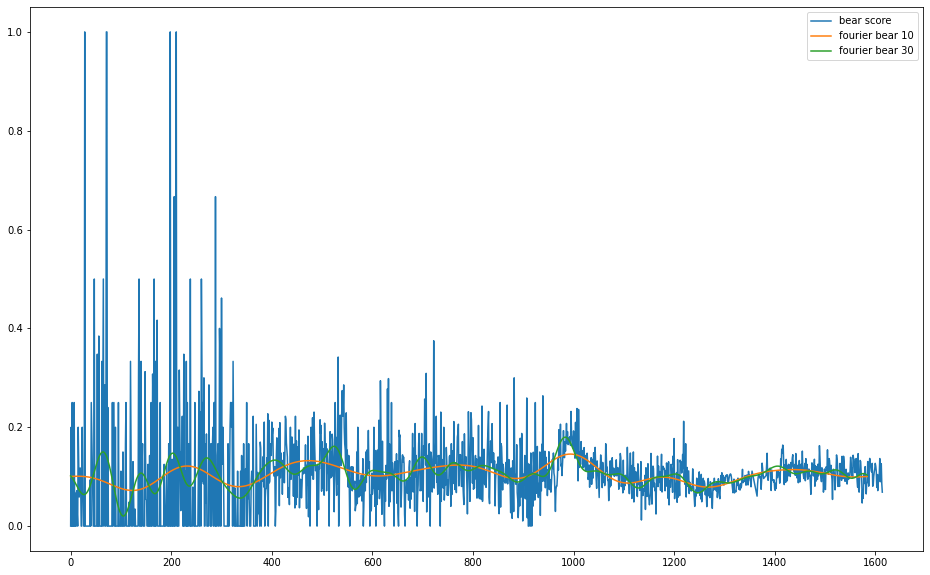

In [ ]:
scores_df[['bear score', 'fourier bear 10', 'fourier bear 30']].plot(figsize=(16, 10));

In [ ]:
#counting null values
print (scores_df.isnull().sum())

bull score          0
bear score          0
Date                0
fourier bull 10    30
fourier bull 30    30
fourier bear 10    30
fourier bear 30    30
dtype: int64


In [ ]:
scores_df.columns

Index(['bull score', 'bear score', 'Date'], dtype='object')

In [ ]:
scores_df1=scores_df.set_index('Date')#setting date column as index

In [ ]:
#counting null values
print (scores_df1.isnull().sum())

bull score         0
bear score         0
fourier bull 10    0
fourier bull 30    0
fourier bear 10    0
fourier bear 30    0
dtype: int64


In [ ]:
scores_df1.index = pd.to_datetime(scores_df1.index)

In [ ]:
idx = pd.date_range('07-01-2017', '12-01-2021')
scores_df1 = scores_df1.reindex(idx)#Filling missing dates with NaNs to make th dataframe continuous

In [ ]:
#counting null values
print (scores_df1.isnull().sum())

bull score         30
bear score         30
fourier bull 10    60
fourier bull 30    60
fourier bear 10    60
fourier bear 30    60
dtype: int64


In [ ]:
scores_df1['Date']=scores_df1.index

In [ ]:
#counting null values
print (scores_df1.isnull().sum())

bull score         30
bear score         30
fourier bull 10    30
fourier bull 30    30
fourier bear 10    30
fourier bear 30    30
Date                0
dtype: int64


In [ ]:
scores_df2=scores_df1.reset_index(drop=True)

In [ ]:
scores_df2.head()

,bull score,bear score,fourier bull 10,fourier bull 30,fourier bear 10,fourier bear 30,Date
0,0.000000,0.00,0.141086,0.147308,0.100437,0.101678,2017-07-01
1,0.200000,0.20,0.141930,0.147118,0.100488,0.100526,2017-07-02
2,0.666667,0.00,0.142778,0.146810,0.100537,0.099251,2017-07-03
3,0.000000,0.25,0.143631,0.146382,0.100585,0.097860,2017-07-04
4,0.400000,0.00,0.144487,0.145833,0.100630,0.096361,2017-07-05


In [ ]:
#counting null values
print (scores_df2.isnull().sum())

bull score         30
bear score         30
fourier bull 10    30
fourier bull 30    30
fourier bear 10    30
fourier bear 30    30
Date                0
dtype: int64


In [ ]:
Final_data.index

RangeIndex(start=0, stop=1791, step=1)

In [ ]:
scores_df2.to_csv("dataset_bull_bear_score_fourier_trans.csv")

### ***Merging the bullish and bearish scores to the final dataframe by using inner join***

In [ ]:
scores_df2=scores_df2.drop(['Unnamed: 0'], axis=1)

In [ ]:
scores_df2.Date = pd.to_datetime(scores_df2.Date)

In [ ]:
scores_df2.columns

Index(['bull score', 'bear score', 'fourier bull 10', 'fourier bull 30',
       'fourier bear 10', 'fourier bear 30', 'Date'],
      dtype='object')

In [ ]:
Final_data=pd.read_csv('Data_google_trends_COVID.csv')

In [ ]:
Final_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search,COVID positiveIncrease,COVID deathIncrease
0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-24,14,0,0
1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-25,14,0,0
2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-26,10,0,0
3,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-27,10,0,0
4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-12-28,10,0,0


In [ ]:
Final_data.Date = pd.to_datetime(Final_data.Date)

In [ ]:
Final_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Open', 'High', 'Low',
       'Close', 'Adj Close', 'Volume', 'MA7', 'MA21', 'MACD', '20SD',
       'upper_band', 'lower_band', 'EMA', 'logmomentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp', 'Date', 'search',
       'COVID positiveIncrease', 'COVID deathIncrease'],
      dtype='object')

In [ ]:
dataset_final = pd.merge(left=Final_data, right=scores_df2, left_on='Date', right_on='Date')

In [ ]:
dataset_final.shape#This will be the dataframe with all the columns (technical indicators, fourier transformed features, google trend, covid data and sentiment score - from 1 July 2017 to 18 Nov 2021)

(1602, 33)

In [ ]:
dataset_final.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Open', 'High', 'Low',
       'Close', 'Adj Close', 'Volume', 'MA7', 'MA21', 'MACD', '20SD',
       'upper_band', 'lower_band', 'EMA', 'logmomentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp', 'Date', 'search',
       'COVID positiveIncrease', 'COVID deathIncrease', 'bull score',
       'bear score', 'fourier bull 10', 'fourier bull 30', 'fourier bear 10',
       'fourier bear 30'],
      dtype='object')

In [ ]:
dataset_final.to_csv('FULL_Data_google_COVID_bull_bear.csv')

In [ ]:
dataset_final.head()

,Unnamed: 0,Unnamed: 0.1,Open,High,Low,Close,Adj Close,Volume,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp,Date,search,COVID positiveIncrease,COVID deathIncrease,bull score,bear score,fourier bull 10,fourier bull 30,fourier bear 10,fourier bear 30
0,189,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-01,17,0,0,0.000000,0.00,0.141086,0.147308,0.100437,0.101678
1,190,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02,17,0,0,0.200000,0.20,0.141930,0.147118,0.100488,0.100526
2,191,191,36.220001,36.325001,35.775002,35.875000,34.054882,57111200.0,36.173571,36.751904,0.303356,0.960520,38.672945,34.830864,35.924548,3.551770,38.458011,0.046984,29.704545,0.102857,43.304973,-0.053955,2017-07-03,15,0,0,0.666667,0.00,0.142778,0.146810,0.100537,0.099251
3,192,192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-04,15,0,0,0.000000,0.25,0.143631,0.146382,0.100585,0.097860
4,193,193,35.922501,36.197498,35.680000,36.022499,34.194897,86278400.0,36.095357,36.634762,0.328795,0.852735,38.340231,34.929292,35.989849,3.555991,38.240991,0.049445,29.954520,0.099254,43.438321,-0.053936,2017-07-05,15,0,0,0.400000,0.00,0.144487,0.145833,0.100630,0.096361
